In [37]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [121]:
long_atr = None

In [ ]:
def tt_split(df_n,vol_metric,scaler:StandardScaler):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["index","Open","Close","High","Low"]].to_numpy()
    y_train = train[vol_metric].to_numpy()
    y_train = scaler.fit_transform(y_train.reshape(-1,1))
    #long_atr = y_train.mean()
    X_train = np.concatenate((X_train,y_train),axis=1)

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["index","Open","Close","High","Low", vol_metric]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    
    y_test = scaler.transform(y_test.reshape(-1,1))
    X_test = np.concatenate((X_test,y_test),axis=1)
    return X_train,y_train,X_test,y_test
    

#X_train,y_train,X_test,y_test = tt_split(df_n,"ATR_normalized")

#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [ ]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 6] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32)#.unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32)#.unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
#X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [24]:
def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
#loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [ ]:
#define lstm model

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        #print(input.shape)
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [131]:
def PDE_loss(t,atr,long_atr,k=3):
    #da/dt = k(theta-atr)
    da_dt = torch.autograd.grad(outputs= atr,inputs= t,grad_outputs=torch.ones_like(atr),create_graph=True)
    return da_dt-k*(long_atr-atr)

In [26]:
def get_cleaned_df(ticker,start,end):
    df = get_stock(ticker,start_date=start,end_date=end,s_window=14,l_window=50)
    df_n= df.xs(ticker,axis=1,level=1)
    
        #define ATR columns
    high = df_n["High"]
    low = df_n["Low"]
    close = df_n["Close"]

    prev_close = close.shift(1)


    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df_n["ATR"] = tr.rolling(7).mean()
    
    log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
    df_n["SD_Log_Close"] = log_diff.rolling(7).std()
    df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
    df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()

    df_n = df_n.dropna()
    df_n = df_n.reset_index().reset_index()
    df_n["index"] = df_n.index%7
    return df_n

In [162]:
def get_trained_model(df,scaler,metric="ATR"):
    X_train,y_train,X_test,y_test = tt_split(df, metric,scaler)


    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=6,output_size=1)
    epochs = 50
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    pde_crit = MSELoss()
    losses = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            #t = input[-1][:,0]
            
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            #print("T shape: ",t.shape)
            loss = crit(out,y_atr)# + pde_crit(PDE_loss(t,out,long_atr))
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        print(f"Epoch {i+1} | Training Loss: {running_loss}")
        losses.append(running_loss)

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title(f"Training Loss of LSTM ({metric}) across {epochs} epochs for {ticker}")
    plt.show()
    return model
    

In [191]:
import numpy as np
import pandas as pd

def backtest_atr_strategy(data: pd.DataFrame,
                          lstm_model,
                          scaler:StandardScaler,
                          vol_metric:str,
                          ini_cash=10000,
                          T: int = 30,
                          R: float = 1000.0,):
    """
    Backtest a simple ATR‑based mean‑reversion strategy:
      - Predict next ATR with an LSTM
      - If predicted ATR is unusually high → go flat (sell)
      - If unusually low → go long
    Assumes 'data' has columns ['Open','High','Low','Close','ATR'].
    'scaler' is a fitted StandardScaler on the train-period ATR.
    """
    cash = ini_cash
    shares = 0.0

    buys = []
    sells = []
    passive_shares = ini_cash/data.loc[T,"Open"]
    # Precompute rolling IQR thresholds on ATR over T bars
    # (we’ll compute quantiles on‑the‑fly inside the loop)
    for i in range(T, len(data)-1):
        window_atr = data[vol_metric].iloc[i-T:i]
        q1 = window_atr.quantile(0.25)
        q3 = window_atr.quantile(0.75)
        med = window_atr.quantile(0.50)
        iqr = q3 - q1
        lower = med - 1.5 * iqr
        upper = med + 1.5 * iqr

        # Prepare model input: last T bars of OHLC + normalized ATR
        X = data[['index','Open','High','Low','Close']].iloc[i-T:i].copy()
        X['ATR_norm'] = scaler.transform(data[[vol_metric]].iloc[i-T:i])  # shape (T,1)
        # reshape to (1, T, features)
        #print(X)
        model_in = torch.tensor(X.values.reshape(T,1, X.shape[1])).to(torch.float32)
        # Predict next normalized ATR, then denormalize
        atr_next_norm = lstm_model(model_in)
        #print(atr_next_norm.shape)
        atr_next_norm=atr_next_norm.item()
        atr_next = scaler.inverse_transform([[atr_next_norm]])[0,0]

        # next bar’s prices
        open_next  = data['Open'].iloc[i+1]
        close_next = data['Close'].iloc[i+1]

        # entry/exit signals
        if atr_next > upper and shares > 0:
            sells.append(i)
            # sell all
            cash += shares * close_next
            print(f"On the {i}th day, sold {shares} shares for ${shares*close_next}")
            shares = 0.0
            
        elif atr_next < lower:
            # buy: risk R = shares * ATR_next -> shares = R / ATR_next
            target_shares = R / atr_next
            # adjust cash & position
            delta = max(target_shares - shares,0)
            if cash<delta*open_next:
                for j in range(int(delta)):
                    if cash>j*open_next:
                        delta = j
            cash -= delta * open_next
            shares+=delta
            print(f"On the {i}th day, Bought {delta} shares for ${delta*open_next}")
            buys.append(i)

    # At end, mark-to-market at last close
    final_value = cash + shares * data['Close'].iloc[-1]
    passive_value = passive_shares*data['Close'].iloc[-1]
    return final_value, cash, shares,passive_value,buys,sells

In [220]:
def backtest_atr_strategy_del(data: pd.DataFrame,
                          lstm_model,
                          scaler:StandardScaler,
                          vol_metric:str,
                          ini_cash=10000,
                          T: int = 30,
                          R: float = 1000.0,):
    """
    Backtest a simple ATR‑based mean‑reversion strategy:
      - Predict next ATR with an LSTM
      - If predicted ATR is unusually high → go flat (sell)
      - If unusually low → go long
    Assumes 'data' has columns ['Open','High','Low','Close','ATR'].
    'scaler' is a fitted StandardScaler on the train-period ATR.
    """
    cash = ini_cash
    shares = 0.0

    buys = []
    sells = []
    preds = []
    passive_shares = ini_cash/data.loc[T,"Open"]
    # Precompute rolling IQR thresholds on ATR over T bars
    # (we’ll compute quantiles on‑the‑fly inside the loop)
    for i in range(T, len(data)-1):
        window_atr = data[vol_metric].iloc[i-T:i]
        q1 = window_atr.quantile(0.25)
        q3 = window_atr.quantile(0.75)
        med = window_atr.quantile(0.50)
        iqr = q3 - q1
        lower = med - 1.5 * iqr
        upper = med + 1.5 * iqr

        # Prepare model input: last T bars of OHLC + normalized ATR
        X = data[['index','Open','High','Low','Close']].iloc[i-T:i].copy()
        X['ATR_norm'] = scaler.transform(data[[vol_metric]].iloc[i-T:i])  # shape (T,1)
        # reshape to (1, T, features)
        #print(X)
        model_in = torch.tensor(X.values.reshape(T,1, X.shape[1])).to(torch.float32)
        # Predict next normalized ATR, then denormalize
        atr_next_norm = lstm_model(model_in)
        #print(atr_next_norm.shape)
        atr_next_norm=atr_next_norm.item()
        atr_next = scaler.inverse_transform([[atr_next_norm]])[0,0]
        atr_prev=med
        if i != T:
            atr_prev = preds[-1]
        preds.append(atr_next)
        # next bar’s prices
        open_next  = data['Open'].iloc[i+1]
        close_next = data['Close'].iloc[i+1]

        # entry/exit signals
        if atr_next-atr_prev > .75*iqr and shares > 0:
            sells.append(i)
            # sell all
            cash += shares * close_next
            print(f"On the {i}th day, sold {shares} shares for ${shares*close_next}")
            shares = 0.0
            
        elif atr_next-atr_prev<-.75*iqr:
            # buy: risk R = shares * ATR_next -> shares = R / ATR_next
            target_shares = R / atr_next
            # adjust cash & position
            delta = max(target_shares - shares,0)
            if cash<delta*open_next:
                for j in range(int(delta)):
                    if cash>j*open_next:
                        delta = j
            cash -= delta * open_next
            shares+=delta
            print(f"On the {i}th day, Bought {delta} shares for ${delta*open_next}")
            buys.append(i)

    # At end, mark-to-market at last close
    final_value = cash + shares * data['Close'].iloc[-1]
    passive_value = passive_shares*data['Close'].iloc[-1]
    return final_value, cash, shares,passive_value,buys,sells

In [206]:
def get_model_preds(df:pd.DataFrame,model,scaler,vol_metric="ATR"):
    preds = []
    T=30
    for i in range(T, len(df)-1):
        df_window = np.array(df[["index","Open","Close","High","Low"]].iloc[i-T:i])
        metric = scaler.transform(np.array(df[vol_metric].iloc[i-T:i]).reshape(-1,1))
        df_window = np.concatenate((df_window,metric),axis=1)
        df_window = df_window.reshape(T,1,6) #6 is number of features
        
        input = torch.tensor(df_window,dtype=torch.float32)
        pred = scaler.inverse_transform([[model(input).item()]])[0,0]
        preds.append(pred)
    return preds

In [182]:
ticker = 'SPY'
start = '2001-01-01'
end = '2022-07-07'
start_n = '2023-01-01'
end_n = '2024-01-01'
data = get_cleaned_df(ticker,start,end)

[*********************100%***********************]  1 of 1 completed

read  5411  lines of data for ticker:  SPY


Epoch 1 | Training Loss: 0.9751719863099211
Epoch 2 | Training Loss: 0.901620286571629
Epoch 3 | Training Loss: 0.8257422929300982
Epoch 4 | Training Loss: 0.6700891006518813
Epoch 5 | Training Loss: 0.47604730889639435
Epoch 6 | Training Loss: 0.28606326521976905
Epoch 7 | Training Loss: 0.22400064895148664
Epoch 8 | Training Loss: 0.19802944926435456
Epoch 9 | Training Loss: 0.15275980093899896
Epoch 10 | Training Loss: 0.13941538202411988
Epoch 11 | Training Loss: 0.12720970037009785
Epoch 12 | Training Loss: 0.12016974955194575
Epoch 13 | Training Loss: 0.13985773973057375
Epoch 14 | Training Loss: 0.10740919186569312
Epoch 15 | Training Loss: 0.09853132323854986
Epoch 16 | Training Loss: 0.09603752702584162
Epoch 17 | Training Loss: 0.08792441982008956
Epoch 18 | Training Loss: 0.08524431652553818
Epoch 19 | Training Loss: 0.07801950783194865
Epoch 20 | Training Loss: 0.074331423117067
Epoch 21 | Training Loss: 0.07333852452061632
Epoch 22 | Training Loss: 0.06901750576627605
Epoc

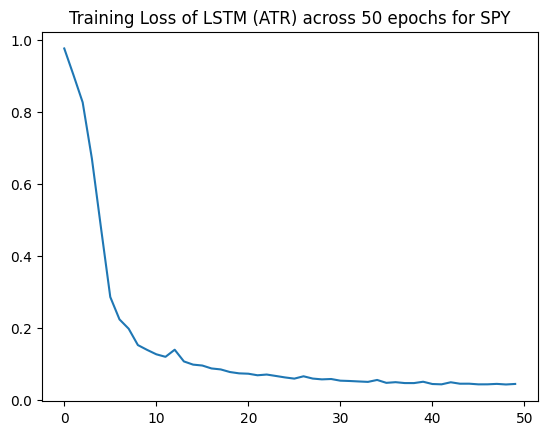

In [193]:
scaler = StandardScaler()
model = get_trained_model(data,scaler = scaler)

Epoch 1 | Training Loss: 0.8336862007922986
Epoch 2 | Training Loss: 0.6425705634276656
Epoch 3 | Training Loss: 0.5063514067407917
Epoch 4 | Training Loss: 0.42637870964758534
Epoch 5 | Training Loss: 0.3210292203242288
Epoch 6 | Training Loss: 0.28027515496839495
Epoch 7 | Training Loss: 0.23671316815649762
Epoch 8 | Training Loss: 0.20464099286233678
Epoch 9 | Training Loss: 0.18243174375418356
Epoch 10 | Training Loss: 0.1647878687363118
Epoch 11 | Training Loss: 0.1468992093577981
Epoch 12 | Training Loss: 0.14322597122586825
Epoch 13 | Training Loss: 0.1406604090486379
Epoch 14 | Training Loss: 0.1328687798779677
Epoch 15 | Training Loss: 0.13122931763748913
Epoch 16 | Training Loss: 0.14090197621022954
Epoch 17 | Training Loss: 0.12004382941214477
Epoch 18 | Training Loss: 0.11346214138628806
Epoch 19 | Training Loss: 0.11596137430409298
Epoch 20 | Training Loss: 0.11298699156545541
Epoch 21 | Training Loss: 0.12188894549549065
Epoch 22 | Training Loss: 0.10954716609900489
Epoch

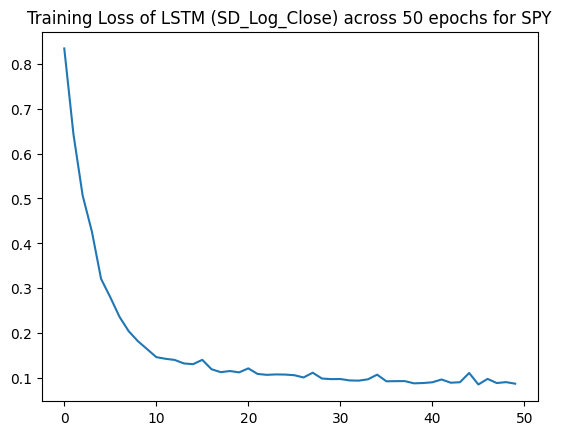

In [208]:
scaler_sd = StandardScaler()
model_sd = get_trained_model(data,scaler = scaler_sd,metric = "SD_Log_Close")

In [183]:
data_test = get_cleaned_df(ticker,start_n,end_n)

[*********************100%***********************]  1 of 1 completed

read  250  lines of data for ticker:  SPY


In [223]:
final_value, money, shares,passive_value,buy_points,sell_points = backtest_atr_strategy_del(data_test,model_sd,scaler_sd,"SD_Log_Close")
print(f"Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
print(f"Passive Value {passive_value}")

On the 30th day, Bought 25 shares for $9930.75
On the 31th day, sold 25.0 shares for $9868.5
On the 34th day, Bought 24 shares for $9721.2
On the 37th day, sold 24.0 shares for $9397.44
On the 38th day, Bought 24 shares for $9383.76
On the 39th day, sold 24.0 shares for $9248.64
On the 41th day, Bought 24 shares for $9261.36
On the 42th day, Bought 0 shares for $0.0
On the 43th day, Bought 0 shares for $0.0
On the 45th day, sold 24.0 shares for $9573.84
On the 50th day, Bought 24 shares for $9498.48
On the 55th day, Bought 0 shares for $0.0
On the 57th day, sold 24.0 shares for $9820.56
On the 111th day, Bought 23 shares for $9950.26
On the 114th day, Bought 0 shares for $0.0
On the 126th day, sold 23.0 shares for $10446.37
On the 127th day, Bought 23 shares for $10465.23
On the 128th day, Bought 0 shares for $0.0
On the 130th day, sold 23.0 shares for $10446.6
On the 132th day, Bought 23 shares for $10452.810000000001
On the 135th day, sold 23.0 shares for $10529.17
On the 136th day, 

30
34
38
41
42
43
50
55
111
114
127
128
132
136
140
142
146
147
151
154
156
158
164
165
176
179
181
183
185
191
192
196
197
201
202
203
210
211
216
219
223


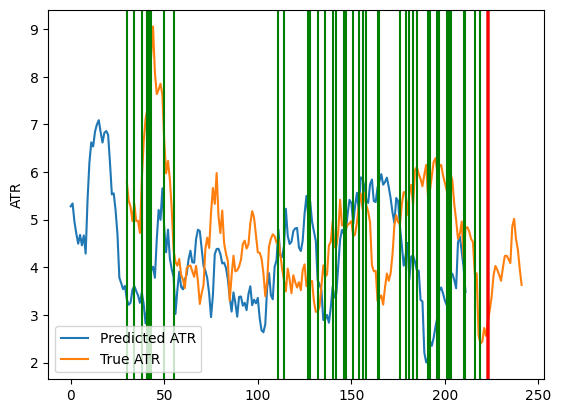

In [224]:
T=30
atr_preds = get_model_preds(data_test,model,scaler)
true_atr = data_test["ATR"].iloc[T:len(data_test)-1]
sns.lineplot(atr_preds,label="Predicted ATR")
sns.lineplot(true_atr,label="True ATR")
plt.legend()
for buy in buy_points:
    print(buy)
    plt.axvline(x=buy,label="Buy",color="Green")
for sell in sell_points:
    plt.axvline(x=buy,label="Sell",color="Red")

In [180]:
data_test.head()

Price,index,Date,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close,ATR_normalized,SD_normalized
0,0,2021-01-13,378.69,380.86,377.85,379.79,45303600,356.56,4.728571,0.006609,-0.476999,-0.596083
1,1,2021-01-14,380.59,381.13,378.10,378.46,49989100,355.31,4.525714,0.007059,-0.565433,-0.500477
2,2,2021-01-15,376.72,377.58,373.70,375.70,107160000,352.72,4.082857,0.007789,-0.758494,-0.345518
3,3,2021-01-19,378.34,379.23,376.75,378.65,51233300,355.49,3.680000,0.005946,-0.934118,-0.736712
4,4,2021-01-20,381.11,384.79,380.69,383.89,61836100,360.41,3.930000,0.007770,-0.825131,-0.349543


NN_LSTM(
  (lstm): LSTM(6, 30)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)